In [1]:
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import tifffile as tiff

In [60]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_CONSTANT)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='nearest').reshape(shape)


(3509, 2405, 3) (3509, 2405)


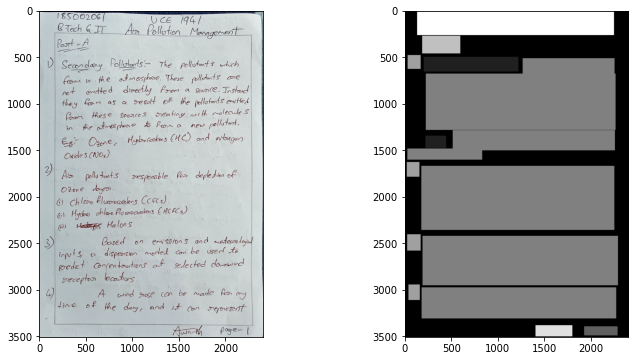

(3509, 2405, 2)


In [2]:
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(0,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(0,))

# Load images
im = cv2.imread("1.jpg", -1)
im_mask = cv2.imread("1.tiff", -1)
print(im.shape, im_mask.shape)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(im,cmap='brg')
plt.subplot(122)
plt.imshow(im_mask,cmap='gray')
plt.show()
# Draw grid lines
# draw_grid(im, 50)
# draw_grid(im_mask, 50)
im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)
print(im_merge.shape)

In [33]:
im_merge.shape
im.shape

(3509, 2405)

210.49600768089294
(3509, 2405)


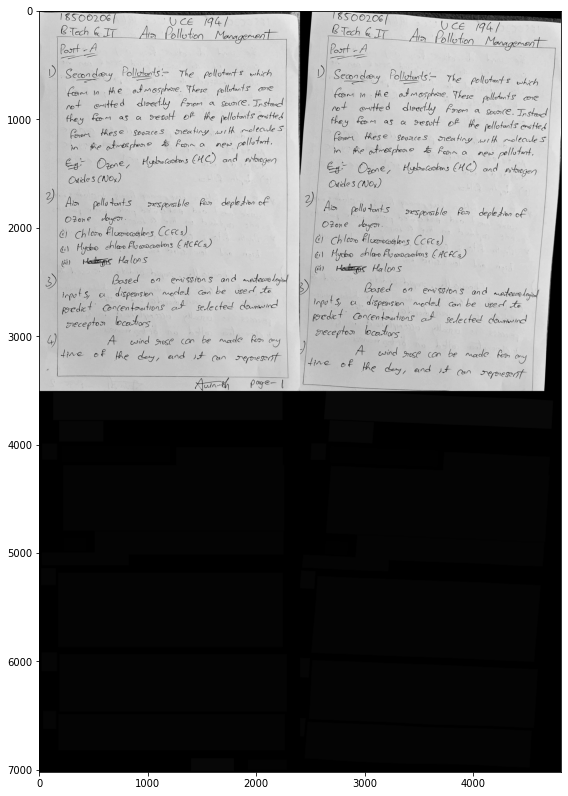

In [30]:
%matplotlib inline

# Apply transformation on image
# import time
# seconds = time.time()
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)
# print((time.time()-seconds))
# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]
print(im_mask.shape)
# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')

In [3]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003].
    
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    h, w = image.shape[:2]
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    dx = gaussian_filter((random_state.rand(h,w) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(h,w) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    
    if len(image.shape) > 2:
        c = image.shape[2]
        distored_image = [map_coordinates(image[:,:,i], indices, order=1, mode='reflect') for i in range(c)]
        distored_image = np.concatenate(distored_image, axis=1)
    else:
        distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    random_state.seed(32)
    return distored_image.reshape(image.shape)

In [6]:
im = cv2.imread('1.jpg')
im_mask = tiff.imread('1.tiff')

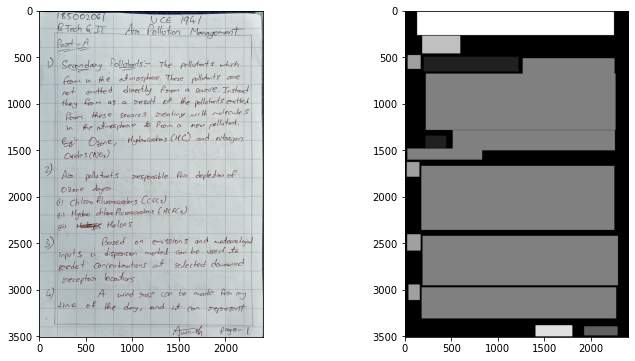

In [7]:
draw_grid(im,200)
# draw_grid(im_mask,200)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.subplot(122)
plt.imshow(im_mask,cmap='gray')

plt.show()

In [4]:
rand_state = np.random.RandomState(32)

im_t = elastic_transform(im_merge,im_merge.shape[1] * 2, im_merge.shape[1] * 0.06,rand_state)
# im_t_2 = elastic_transform(im,im.shape[1]*1, im.shape[1] *0.08,rand_state)


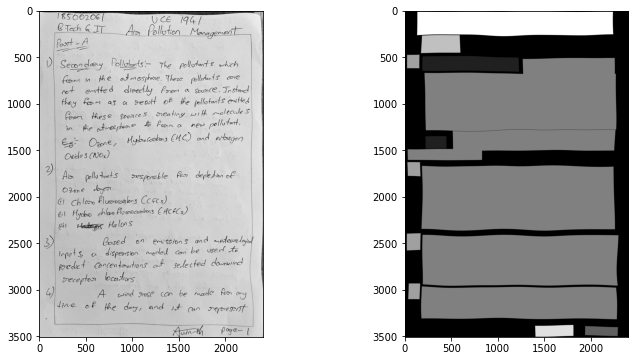

In [5]:
im_et = im_t[...,0]
im_mask_et = im_t[...,1]
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(im_et,cmap='gray')
plt.subplot(122)
plt.imshow(im_mask_et,cmap='gray')

plt.show()

In [14]:
im_mask_t = elastic_transform(im_mask,im_mask.shape[1] * 2, im_mask.shape[1] * 0.06,rand_state)


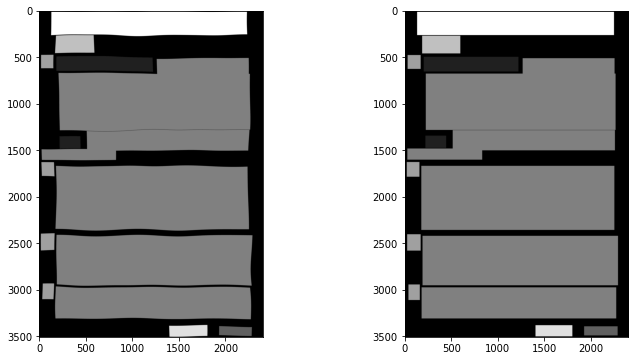

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(im_mask_t,cmap='gray')
plt.subplot(122)
plt.imshow(im_mask,cmap='gray')

plt.show()